In [1]:
%store -r merged_df

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

#auto arima time series modeling package
from pmdarima import auto_arima
#seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

## MODEL PREP AND MODELING DATA



Reindex with qtr_begin_dt. Group by product_fda_list_name and qtr_begin_dt to sum units/amounts. Split by DEA Schedule, MAT vs non-MAT. Create smaller subset that is date and units_per_1000

In [3]:
grouped_df = merged_df.groupby(['qtr_begin_dt','mat_x','opioid','dea_schedule','product_fda_list_name']).sum()


In [4]:
grp_dea_sched_df = merged_df.groupby(['qtr_begin_dt','mat_x','opioid','dea_schedule','enrollment']).sum().reset_index()

In [5]:
grp_dea_sched_df.set_index(pd.DatetimeIndex(grp_dea_sched_df['qtr_begin_dt']), inplace = True)
grp_dea_sched_df.drop(columns = ['qtr_begin_dt'], inplace = True)

In [6]:
grp_dea_sched_df.head()

,mat_x,opioid,dea_schedule,enrollment,total_amount_reimbursed,units_reimbursed,units_per_1000,amount_per_1000
qtr_begin_dt,,,,,,,,
2015-01-01,0,1,CII,1.259749e+06,3480933.12,6858087.43,5444.012454,2763.196511
2015-01-01,0,1,CIII,1.259749e+06,220893.23,335836.00,266.589685,175.347064
2015-01-01,0,1,CIV,1.259749e+06,94139.87,841797.00,668.226149,74.729089
2015-01-01,0,1,CV,1.259749e+06,2722.34,66911.78,53.115182,2.161018
2015-01-01,1,1,CII,1.259749e+06,31869.02,189851.00,150.705458,25.297919


In [7]:
CII = grp_dea_sched_df.loc[grp_dea_sched_df['dea_schedule']== 'CII']
CIII = grp_dea_sched_df.loc[grp_dea_sched_df['dea_schedule']== 'CIII']

CIV = grp_dea_sched_df.loc[grp_dea_sched_df['dea_schedule']== 'CIV']

CV = grp_dea_sched_df.loc[grp_dea_sched_df['dea_schedule']== 'CV']

MAT_df = grp_dea_sched_df.loc[grp_dea_sched_df['mat_x'] == 1]
Non_MAT_df = grp_dea_sched_df.loc[grp_dea_sched_df['mat_x']==0]

In [8]:
CII.head()

,mat_x,opioid,dea_schedule,enrollment,total_amount_reimbursed,units_reimbursed,units_per_1000,amount_per_1000
qtr_begin_dt,,,,,,,,
2015-01-01,0,1,CII,1.259749e+06,3480933.12,6858087.43,5444.012454,2763.196511
2015-01-01,1,1,CII,1.259749e+06,31869.02,189851.00,150.705458,25.297919
2015-04-01,0,1,CII,1.269057e+06,2331363.77,4306551.47,3393.506045,1837.084057
2015-04-01,1,1,CII,1.269057e+06,5094.11,25444.00,20.049538,4.014092
2015-07-01,0,1,CII,1.262296e+06,1351597.55,3576911.91,2833.655426,1070.745332


First approach is to trend/forecast based on each class of drugs. 

In [9]:
CII_Non_MAT = CII.loc[CII['mat_x']== 0]
CIII_Non_MAT = CIII.loc[CIII['mat_x']== 0]
CIV_Non_MAT = CIV.loc[CIV['mat_x']== 0]
CV_Non_MAT = CV.loc[CV['mat_x']== 0]



In [10]:
CV_Non_MAT['units_per_1000'].unique()

array([ 53.11518223,  76.35317047,  82.45402029, 105.66775389,
       319.17759739,  32.10821545,   9.62239438,   9.93500471,
       340.55170718, 215.20966192, 167.84324158, 238.42999096,
       238.44368746, 134.54807484, 114.1781621 , 165.77280316,
       182.54948342,  96.8980509 ,  79.27828128,  66.31377313])

In [11]:
CII_Non_MAT.loc[:,"units_per_1000"] = pd.to_numeric(CII_Non_MAT["units_per_1000"], errors = "coerce")
CIII_Non_MAT.loc[:,"units_per_1000"] = pd.to_numeric(CIII_Non_MAT["units_per_1000"], errors = "coerce")
CIV_Non_MAT.loc[:,"units_per_1000"] = pd.to_numeric(CIV_Non_MAT["units_per_1000"], errors = "coerce")
CV_Non_MAT.loc[:,"units_per_1000"] = pd.to_numeric(CV_Non_MAT["units_per_1000"], errors = "coerce")

/Users/shishi/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [12]:
grp_dea_sched_df.columns

Index(['mat_x', 'opioid', 'dea_schedule', 'enrollment',
       'total_amount_reimbursed', 'units_reimbursed', 'units_per_1000',
       'amount_per_1000'],
      dtype='object')

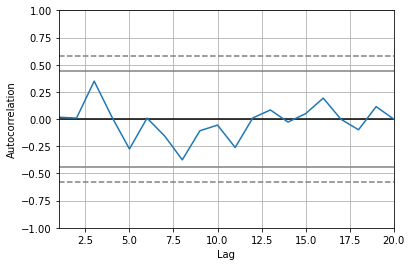

In [13]:
pd.plotting.autocorrelation_plot(CIV_Non_MAT.units_per_1000);

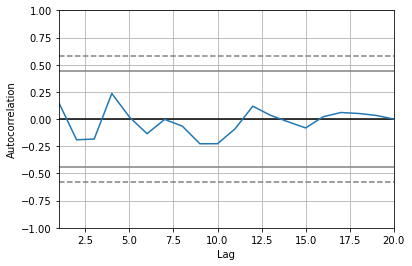

In [14]:
pd.plotting.autocorrelation_plot(CV_Non_MAT.units_per_1000);

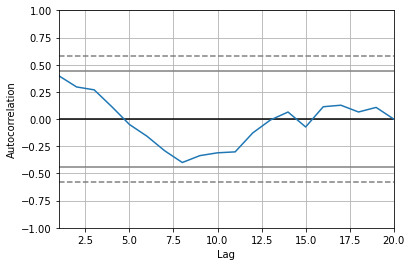

In [15]:
pd.plotting.autocorrelation_plot(CIII_Non_MAT.units_per_1000);

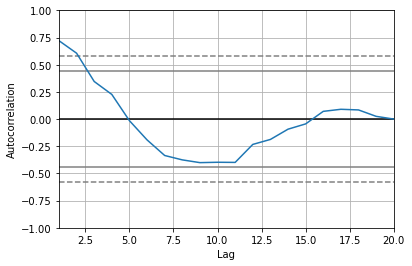

In [16]:
pd.plotting.autocorrelation_plot(CII_Non_MAT.units_per_1000);

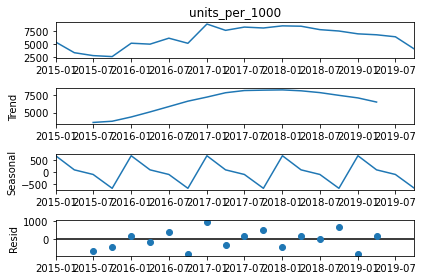

In [17]:
# Decompose time series into trend, seasonal, and residual components.
decomp = seasonal_decompose(CII_Non_MAT['units_per_1000'])

# Plot the decomposed time series.
decomp.plot();

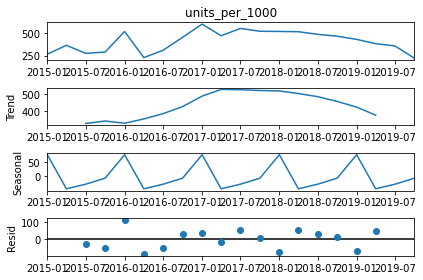

In [18]:
# Decompose time series into trend, seasonal, and residual components.
decomp = seasonal_decompose(CIII_Non_MAT['units_per_1000'])

# Plot the decomposed time series.
decomp.plot();

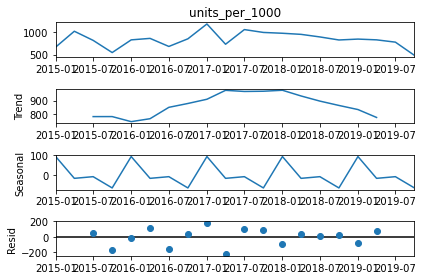

In [19]:
# Decompose time series into trend, seasonal, and residual components.
decomp = seasonal_decompose(CIV_Non_MAT['units_per_1000'])

# Plot the decomposed time series.
decomp.plot();

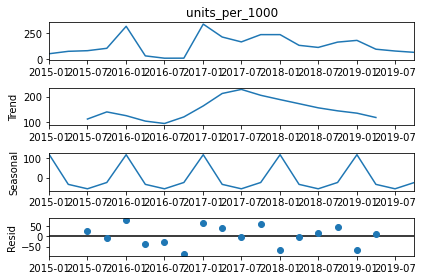

In [20]:
# Decompose time series into trend, seasonal, and residual components.
decomp = seasonal_decompose(CV_Non_MAT['units_per_1000'])

# Plot the decomposed time series.
decomp.plot();

Based on the decomposition and autocorrelation plots, the seasonality and trend for each class is generally similar. Instead of a breakdown by class, trend and forecast based on all opioids dispensed. Use MAT vs non-MAT to classify. 

Using functions from statsmodels.api documentation, performing Dickey-Fuller and KPSS to test for stationarity with MAT vs Non_MAT timeseries. 

In [21]:
MAT_df = MAT_df.groupby(['qtr_begin_dt','mat_x','opioid','enrollment']).sum()
MAT_df = MAT_df[['units_per_1000']]




In [22]:
Non_MAT_df = Non_MAT_df.groupby(['qtr_begin_dt','mat_x','opioid','enrollment']).sum()
Non_MAT_df = Non_MAT_df[['units_per_1000']]

In [23]:
MAT_df.head()

,,,,units_per_1000
qtr_begin_dt,mat_x,opioid,enrollment,
2015-01-01,1,1,1.259749e+06,1467.021993
2015-04-01,1,1,1.269057e+06,1174.649233
2015-07-01,1,1,1.262296e+06,816.843672
2015-10-01,1,1,1.269899e+06,774.852488
2016-01-01,1,1,1.279065e+06,966.010858


In [24]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [25]:
from statsmodels.tsa.stattools import kpss
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [26]:
adf_test(MAT_df)

Results of Dickey-Fuller Test:
Test Statistic                -21.310598
p-value                         0.000000
#Lags Used                      8.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64


In [27]:
kpss_test(MAT_df)

Results of KPSS Test:
Test Statistic           0.611901
p-value                  0.021554
Lags Used                2.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


In [28]:
adf_test(Non_MAT_df)

Results of Dickey-Fuller Test:
Test Statistic                 -1.217411
p-value                         0.666062
#Lags Used                      1.000000
Number of Observations Used    18.000000
Critical Value (1%)            -3.859073
Critical Value (5%)            -3.042046
Critical Value (10%)           -2.660906
dtype: float64


In [29]:
kpss_test(Non_MAT_df)

Results of KPSS Test:
Test Statistic           0.341503
p-value                  0.100000
Lags Used                2.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/Users/shishi/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


Data does not appear to be stationary. Trying differencing by subtracting one shift and then 2 shifts. Plot. 

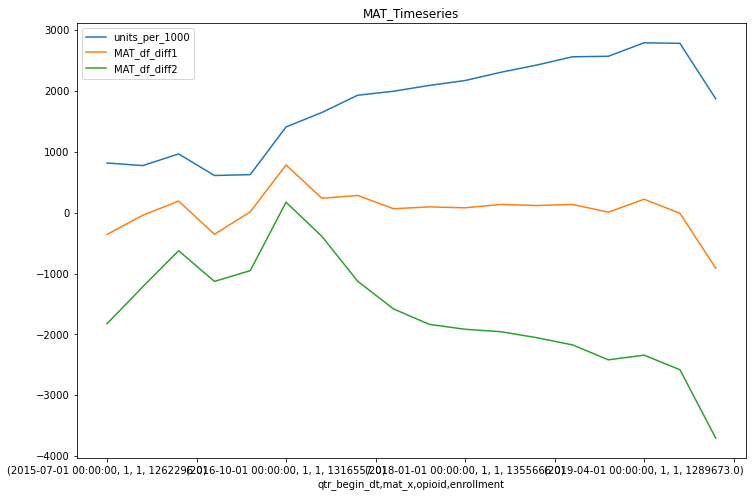

In [30]:
MAT_df['MAT_df_diff1'] = MAT_df['units_per_1000'] - MAT_df['units_per_1000'].shift(1)
MAT_df['MAT_df_diff2'] = MAT_df['MAT_df_diff1'] - MAT_df['units_per_1000'].shift(2)
MAT_df= MAT_df.dropna()
MAT_df['units_per_1000'].plot(figsize =(12,8), legend = True, title = 'MAT_Timeseries')
MAT_df['MAT_df_diff1'].plot(figsize = (12,8), legend = True)
MAT_df['MAT_df_diff2'].plot(figsize = (12,8), legend = True)

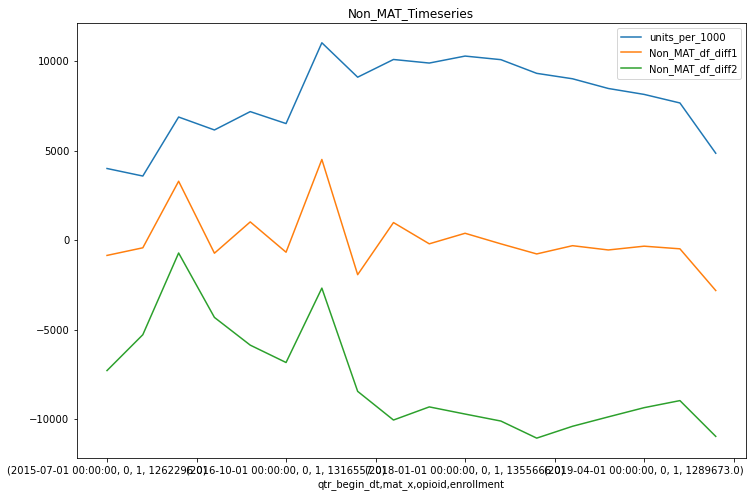

In [31]:
Non_MAT_df['Non_MAT_df_diff1'] = Non_MAT_df['units_per_1000'] - Non_MAT_df['units_per_1000'].shift(1) 
Non_MAT_df['Non_MAT_df_diff2'] = Non_MAT_df['Non_MAT_df_diff1'] - Non_MAT_df['units_per_1000'].shift(2)
Non_MAT_df= Non_MAT_df.dropna()
Non_MAT_df['units_per_1000'].plot(figsize = (12,8), legend = True, title = 'Non_MAT_Timeseries')
Non_MAT_df['Non_MAT_df_diff1'].plot(figsize = (12,8), legend = True)
Non_MAT_df['Non_MAT_df_diff2'].plot(figsize = (12,8), legend = True)

Interestingly, the MAT units_per_1000 time series demonstrates stationarity, but the non-MAT timeseries does not demonstrate stationarity, even with differentiation

In [32]:
adf_test(Non_MAT_df['Non_MAT_df_diff1'])

Results of Dickey-Fuller Test:
Test Statistic                 -2.183427
p-value                         0.212315
#Lags Used                      1.000000
Number of Observations Used    16.000000
Critical Value (1%)            -3.924019
Critical Value (5%)            -3.068498
Critical Value (10%)           -2.673893
dtype: float64


In [33]:
kpss(Non_MAT_df['Non_MAT_df_diff1'])

/Users/shishi/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/Users/shishi/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


(0.3171721597125794,
 0.1,
 8,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [34]:
adf_test(Non_MAT_df['Non_MAT_df_diff2'])

Results of Dickey-Fuller Test:
Test Statistic                 -1.586348
p-value                         0.490448
#Lags Used                      0.000000
Number of Observations Used    17.000000
Critical Value (1%)            -3.889266
Critical Value (5%)            -3.054358
Critical Value (10%)           -2.666984
dtype: float64


In [35]:
kpss_test(Non_MAT_df['Non_MAT_df_diff2'])

Results of KPSS Test:
Test Statistic           0.532127
p-value                  0.034431
Lags Used                2.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


In [36]:
adf_test(MAT_df['MAT_df_diff1'])

Results of Dickey-Fuller Test:
Test Statistic                 -1.806127
p-value                         0.377424
#Lags Used                      7.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64


In [37]:
kpss_test(MAT_df['MAT_df_diff1'])

Results of KPSS Test:
Test Statistic           0.195335
p-value                  0.100000
Lags Used                0.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/Users/shishi/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [38]:
adf_test(MAT_df['MAT_df_diff2'])

Results of Dickey-Fuller Test:
Test Statistic                -7.040230e+00
p-value                        5.872643e-10
#Lags Used                     7.000000e+00
Number of Observations Used    1.000000e+01
Critical Value (1%)           -4.331573e+00
Critical Value (5%)           -3.232950e+00
Critical Value (10%)          -2.748700e+00
dtype: float64


In [39]:
kpss_test((MAT_df['MAT_df_diff2']))

Results of KPSS Test:
Test Statistic           0.543950
p-value                  0.031768
Lags Used                2.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Credit to [Jason Brownlee](https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/) for the code below:

In [41]:
# grid search sarima hyperparameters
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# one-step sarima forecast
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=False):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
	models = list()
	# define config lists
	p_params = [0, 1, 2]
	d_params = [0, 1]
	q_params = [0, 1, 2]
	t_params = ['n','c','t','ct']
	P_params = [0, 1, 2]
	D_params = [0, 1]
	Q_params = [0, 1, 2]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models

if __name__ == '__main__':
	# define dataset
	data = Non_MAT_df['units_per_1000']
	print(data)
	# data split
	n_test = 3
	# model configs
	cfg_list = sarima_configs()
	# grid search
	scores = grid_search(data, cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

qtr_begin_dt  mat_x  opioid  enrollment  
2015-07-01    0      1       1.262296e+06     4008.361185
2015-10-01    0      1       1.269899e+06     3587.526256
2016-01-01    0      1       1.279065e+06     6883.917671
2016-04-01    0      1       1.310312e+06     6161.015056
2016-07-01    0      1       1.308614e+06     7186.327038
2016-10-01    0      1       1.316557e+06     6518.468665
2017-01-01    0      1       1.329612e+06    11031.128156
2017-04-01    0      1       1.338202e+06     9109.175446
2017-07-01    0      1       1.345714e+06    10098.049780
2017-10-01    0      1       1.349776e+06     9898.667650
2018-01-01    0      1       1.355666e+06    10288.757209
2018-04-01    0      1       1.332721e+06    10088.071294
2018-07-01    0      1       1.317721e+06     9323.946778
2018-10-01    0      1       1.296805e+06     9020.707045
2019-01-01    0      1       1.293211e+06     8478.410522
2019-04-01    0      1       1.289673e+06     8147.493512
2019-07-01    0      1       1

In [42]:
if __name__ == '__main__':
	# define dataset
	data = Non_MAT_df['Non_MAT_df_diff1']
	print(data)
	# data split
	n_test = 3
	# model configs
	cfg_list = sarima_configs()
	# grid search
	scores = grid_search(data, cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

qtr_begin_dt  mat_x  opioid  enrollment  
2015-07-01    0      1       1.262296e+06    -846.819937
2015-10-01    0      1       1.269899e+06    -420.834929
2016-01-01    0      1       1.279065e+06    3296.391415
2016-04-01    0      1       1.310312e+06    -722.902615
2016-07-01    0      1       1.308614e+06    1025.311982
2016-10-01    0      1       1.316557e+06    -667.858373
2017-01-01    0      1       1.329612e+06    4512.659491
2017-04-01    0      1       1.338202e+06   -1921.952710
2017-07-01    0      1       1.345714e+06     988.874334
2017-10-01    0      1       1.349776e+06    -199.382131
2018-01-01    0      1       1.355666e+06     390.089559
2018-04-01    0      1       1.332721e+06    -200.685915
2018-07-01    0      1       1.317721e+06    -764.124516
2018-10-01    0      1       1.296805e+06    -303.239732
2019-01-01    0      1       1.293211e+06    -542.296523
2019-04-01    0      1       1.289673e+06    -330.917010
2019-07-01    0      1       1.345640e+06    -

In [43]:
if __name__ == '__main__':
	# define dataset
	data = Non_MAT_df['Non_MAT_df_diff2']
	print(data)
	# data split
	n_test = 3
	# model configs
	cfg_list = sarima_configs()
	# grid search
	scores = grid_search(data, cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

qtr_begin_dt  mat_x  opioid  enrollment  
2015-07-01    0      1       1.262296e+06    -7278.763406
2015-10-01    0      1       1.269899e+06    -5276.016050
2016-01-01    0      1       1.279065e+06     -711.969770
2016-04-01    0      1       1.310312e+06    -4310.428871
2016-07-01    0      1       1.308614e+06    -5858.605689
2016-10-01    0      1       1.316557e+06    -6828.873429
2017-01-01    0      1       1.329612e+06    -2673.667546
2017-04-01    0      1       1.338202e+06    -8440.421375
2017-07-01    0      1       1.345714e+06   -10042.253822
2017-10-01    0      1       1.349776e+06    -9308.557576
2018-01-01    0      1       1.355666e+06    -9707.960221
2018-04-01    0      1       1.332721e+06   -10099.353565
2018-07-01    0      1       1.317721e+06   -11052.881725
2018-10-01    0      1       1.296805e+06   -10391.311026
2019-01-01    0      1       1.293211e+06    -9866.243301
2019-04-01    0      1       1.289673e+06    -9351.624056
2019-07-01    0      1       1

In [44]:
if __name__ == '__main__':
	# define dataset
	data = MAT_df['units_per_1000']
	print(data)
	# data split
	n_test = 3
	# model configs
	cfg_list = sarima_configs()
	# grid search
	scores = grid_search(data, cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

qtr_begin_dt  mat_x  opioid  enrollment  
2015-07-01    1      1       1.262296e+06     816.843672
2015-10-01    1      1       1.269899e+06     774.852488
2016-01-01    1      1       1.279065e+06     966.010858
2016-04-01    1      1       1.310312e+06     611.826420
2016-07-01    1      1       1.308614e+06     625.773429
2016-10-01    1      1       1.316557e+06    1409.948813
2017-01-01    1      1       1.329612e+06    1647.204185
2017-04-01    1      1       1.338202e+06    1931.092892
2017-07-01    1      1       1.345714e+06    1996.796845
2017-10-01    1      1       1.349776e+06    2092.344357
2018-01-01    1      1       1.355666e+06    2172.775964
2018-04-01    1      1       1.332721e+06    2308.933205
2018-07-01    1      1       1.317721e+06    2427.079489
2018-10-01    1      1       1.296805e+06    2563.187773
2019-01-01    1      1       1.293211e+06    2571.887511
2019-04-01    1      1       1.289673e+06    2793.459854
2019-07-01    1      1       1.345640e+06    2

In [45]:
if __name__ == '__main__':
	# define dataset
	data = MAT_df['MAT_df_diff1']
	print(data)
	# data split
	n_test = 3
	# model configs
	cfg_list = sarima_configs()
	# grid search
	scores = grid_search(data, cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

qtr_begin_dt  mat_x  opioid  enrollment  
2015-07-01    1      1       1.262296e+06   -357.805561
2015-10-01    1      1       1.269899e+06    -41.991184
2016-01-01    1      1       1.279065e+06    191.158370
2016-04-01    1      1       1.310312e+06   -354.184438
2016-07-01    1      1       1.308614e+06     13.947009
2016-10-01    1      1       1.316557e+06    784.175384
2017-01-01    1      1       1.329612e+06    237.255372
2017-04-01    1      1       1.338202e+06    283.888707
2017-07-01    1      1       1.345714e+06     65.703954
2017-10-01    1      1       1.349776e+06     95.547512
2018-01-01    1      1       1.355666e+06     80.431607
2018-04-01    1      1       1.332721e+06    136.157241
2018-07-01    1      1       1.317721e+06    118.146284
2018-10-01    1      1       1.296805e+06    136.108284
2019-01-01    1      1       1.293211e+06      8.699738
2019-04-01    1      1       1.289673e+06    221.572343
2019-07-01    1      1       1.345640e+06     -9.325993
2019-1

In [46]:
if __name__ == '__main__':
	# define dataset
	data = MAT_df['MAT_df_diff2']
	print(data)
	# data split
	n_test = 3
	# model configs
	cfg_list = sarima_configs()
	# grid search
	scores = grid_search(data, cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

qtr_begin_dt  mat_x  opioid  enrollment  
2015-07-01    1      1       1.262296e+06   -1824.827554
2015-10-01    1      1       1.269899e+06   -1216.640417
2016-01-01    1      1       1.279065e+06    -625.685303
2016-04-01    1      1       1.310312e+06   -1129.036926
2016-07-01    1      1       1.308614e+06    -952.063849
2016-10-01    1      1       1.316557e+06     172.348965
2017-01-01    1      1       1.329612e+06    -388.518057
2017-04-01    1      1       1.338202e+06   -1126.060107
2017-07-01    1      1       1.345714e+06   -1581.500231
2017-10-01    1      1       1.349776e+06   -1835.545380
2018-01-01    1      1       1.355666e+06   -1916.365239
2018-04-01    1      1       1.332721e+06   -1956.187117
2018-07-01    1      1       1.317721e+06   -2054.629680
2018-10-01    1      1       1.296805e+06   -2172.824921
2019-01-01    1      1       1.293211e+06   -2418.379751
2019-04-01    1      1       1.289673e+06   -2341.615430
2019-07-01    1      1       1.345640e+06   -2